## Modeling (Part A)

## Loading Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
#import xgboost as xg 
import numpy as np 
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/cleaned_data_updated.csv")

data.head()

,Price,Shared Room,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,...,City_Barcelona,City_Berlin,City_Budapest,City_Lisbon,City_Paris,City_Rome,City_Vienna,Day_Weekday,Day_Weekend,Room_Type_Entire home/apt
0,194.033698,False,True,2.0,False,1,0,10.0,93.0,1,...,False,False,False,False,False,False,False,True,False,False
1,344.245776,False,True,4.0,False,0,0,8.0,85.0,1,...,False,False,False,False,False,False,False,True,False,False
2,264.101422,False,True,2.0,False,0,1,9.0,87.0,1,...,False,False,False,False,False,False,False,True,False,False
3,433.529398,False,True,4.0,False,0,1,9.0,90.0,2,...,False,False,False,False,False,False,False,True,False,False
4,485.552926,False,True,2.0,True,0,0,10.0,98.0,1,...,False,False,False,False,False,False,False,True,False,False


In [3]:
X = data.drop('Price', axis=1)
y = data['Price']

# Create bins for the price range based on quantiles for stratification
price_bins = pd.qcut(y, q=10, duplicates='drop') 

# Splitting the data into train, validation, and test sets
# 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=price_bins)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=price_bins.loc[X_temp.index])


## Random Forest Regressor

In [4]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = rf_model.predict(X_val)

# Predict on the test set
y_test_pred = rf_model.predict(X_test)

# Calculating the MSE and RMSE for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Test MSE : %f" % mse_test) 
print("Test RMSE: %f" % rmse_test)

# Calculating the MSE and RMSE for the validation set
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print("Validation MSE : %f" %(mse_val)) 
print("Validation RMSE: %f" % (rmse_val))

Test MSE : 2842.107623
Test RMSE: 53.311421
Validation MSE : 2637.472349
Validation RMSE: 51.356327


### Tuning Radom Forest

Doing a GridSearch in order to find the best parameters

Fitting 3 folds for each of 6 candidates, totalling 18 fits


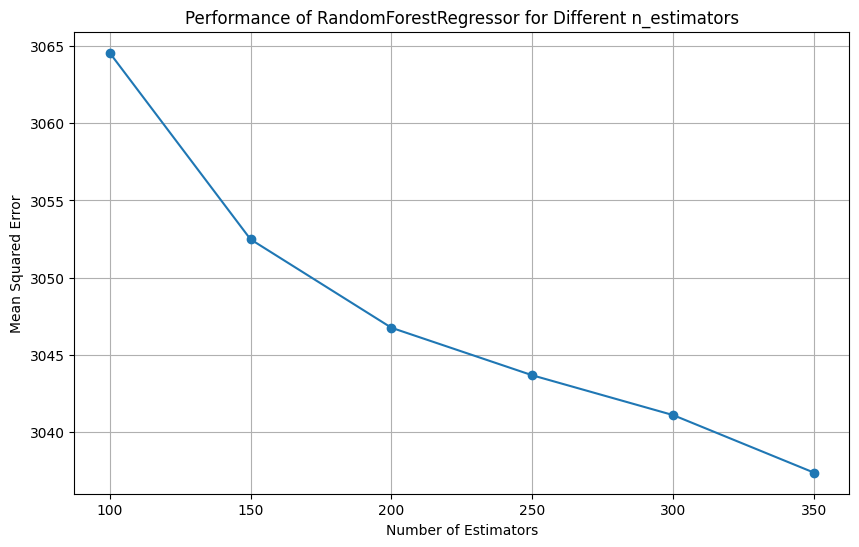

In [5]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300, 350]
}

# Initialize the grid search 
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

# Plotting
results = grid_search.cv_results_

plt.figure(figsize=(10, 6))
plt.plot(results['param_n_estimators'], -results['mean_test_score'], marker='o') 
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.title('Performance of RandomForestRegressor for Different n_estimators')
plt.grid(True)
plt.show()

### Tunned Random Forest

In [7]:
# Initialize the Random Forest Regressor
rf_model_tuned = RandomForestRegressor(random_state=42, n_estimators= best_params['n_estimators'])

# Train the model on the training set
rf_model_tuned.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = rf_model_tuned.predict(X_val)

# Predict on the test set
y_test_pred = rf_model_tuned.predict(X_test)

# Calculating the MSE and RMSE for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Test MSE : %f" % mse_test) 
print("Test RMSE: %f" % rmse_test)

# Calculating the MSE and RMSE for the validation set
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print("Validation MSE : %f" %(mse_val)) 
print("Validation RMSE: %f" % (rmse_val))


Test MSE : 2812.009186
Test RMSE: 53.028381
Validation MSE : 2614.248665
Validation RMSE: 51.129724


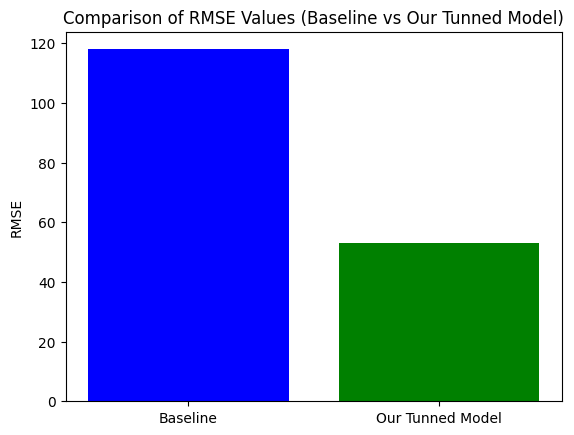

In [11]:
# Visualisation
# Baseline RMSE value from another model
baseline_rmse = 118

# RMSE value for the tuned Random Forest model on the test set
test_rmse = rmse_test

# Plotting the RMSE values
labels = ['Baseline', 'Our Tunned Model']
rmse_values = [baseline_rmse, test_rmse]

plt.bar(labels, rmse_values, color=['blue', 'green'])
plt.ylabel('RMSE')
plt.title('Comparison of RMSE Values (Baseline vs Our Tunned Model)')
# Save the plot as an image file 
#plt.savefig('rmse_comparison.png')
plt.show()

# Protected attribute

In [13]:
df_results = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_test_pred})

# Assuming X_test is your feature DataFrame
# Add the 'Superhost' column to df_results
df_results['Superhost'] = X_test['Superhost'].values

# Calculate average prediction price for Superhosts and non-Superhosts
average_price_superhost = df_results[df_results['Superhost'] == True]['Predicted Price'].mean()
average_price_non_superhost = df_results[df_results['Superhost'] == False]['Predicted Price'].mean()

# Display the results
print("Average Prediction Price for Superhosts: {:.2f}".format(average_price_superhost))
print("Average Prediction Price for Non-Superhosts: {:.2f}".format(average_price_non_superhost))


Average Prediction Price for Superhosts: 209.66
Average Prediction Price for Non-Superhosts: 220.93
